In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics


In [2]:
df = pd.read_csv('../archive/flights.csv')

/var/folders/2w/hy3qhkf90ld86v626flq0kb80000gn/T/ipykernel_10571/3601276550.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../archive/flights.csv')


In [5]:
# Merge origin and destination airport lat/lon, add holiday, and binary weather features
import holidays
from meteostat import Stations, Daily
from datetime import datetime

# Load airports.csv
airports = pd.read_csv('../archive/airports.csv')

# Merge origin airport lat/lon
orig = airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].rename(columns={
    'IATA_CODE': 'ORIGIN_AIRPORT',
    'LATITUDE': 'ORIGIN_AIRPORT_LAT',
    'LONGITUDE': 'ORIGIN_AIRPORT_LON'
})
df = df.merge(orig, on='ORIGIN_AIRPORT', how='left')

# Merge destination airport lat/lon
dest = airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].rename(columns={
    'IATA_CODE': 'DESTINATION_AIRPORT',
    'LATITUDE': 'DEST_AIRPORT_LAT',
    'LONGITUDE': 'DEST_AIRPORT_LON'
})
df = df.merge(dest, on='DESTINATION_AIRPORT', how='left')

# Add US holiday column
df['date'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
us_holidays = holidays.US()
df['is_holiday'] = df['date'].apply(lambda x: 1 if x in us_holidays else 0)

# Add binary weather feature for origin and destination (0: good, 1: bad)
# Here, 'bad' is defined as tavg < 0C, prcp > 5mm, or wspd > 30km/h (customize as needed)
weather_features = ['tavg', 'prcp', 'wspd']
def get_weather_flag(lat, lon, date):
    try:
        stations = Stations().nearby(lat, lon)
        station = stations.fetch(1)
        if not station.empty:
            station_id = station.index[0]
            weather = Daily(station_id, date, date).fetch()
            if not weather.empty:
                tavg = weather['tavg'].values[0] if 'tavg' in weather.columns else 15
                prcp = weather['prcp'].values[0] if 'prcp' in weather.columns else 0
                wspd = weather['wspd'].values[0] if 'wspd' in weather.columns else 10
                # Define 'bad' weather
                if (tavg is not None and tavg < 0) or (prcp is not None and prcp > 5) or (wspd is not None and wspd > 30):
                    return 1
                else:
                    return 0
    except Exception as e:
        pass
    return 0  # Default to good weather if data is missing

# Apply for origin and destination
df['origin_weather_bad'] = df.apply(lambda row: get_weather_flag(row['ORIGIN_AIRPORT_LAT'], row['ORIGIN_AIRPORT_LON'], row['date']), axis=1)
df['dest_weather_bad'] = df.apply(lambda row: get_weather_flag(row['DEST_AIRPORT_LAT'], row['DEST_AIRPORT_LON'], row['date']), axis=1)

print('Added lat/lon for both airports, is_holiday, and binary weather features.')

KeyboardInterrupt: 

In [ ]:
df.columns

In [ ]:
df=df.drop(['AIR_TIME',"ARRIVAL_TIME","TAIL_NUMBER","CANCELLATION_REASON", 'FLIGHT_NUMBER', 'ELAPSED_TIME','WHEELS_ON', 'TAXI_IN',
       'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],axis=1)

In [4]:
# df[['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']] = df[['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']].fillna(0)
df[['DEPARTURE_DELAY']] = df[['DEPARTURE_DELAY']].fillna(0)

In [7]:
# import pandas as pd
from sklearn.preprocessing import LabelEncoder

# # Identify categorical columns (object or string types)
# categorical_cols = df.select_dtypes(include=['object']).columns

# # Initialize LabelEncoder
# le = LabelEncoder()

# # Apply label encoding column by column
# for col in categorical_cols:
#     df[col] = le.fit_transform(df[col].astype(str))  # convert to string to avoid NaN issues

# print(df.head())

In [8]:
import pickle

label_encoders = {}

categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le


# Save all fitted encoders to disk
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)


print('Saved label_encoders.pkl with encoders for:', list(label_encoders.keys()))

Saved label_encoders.pkl with encoders for: ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']


In [9]:
result=[]
for row in df['ARRIVAL_DELAY']:
    if row > 15:
        result.append(1)
    else:
        result.append(0)

In [10]:
df=df.drop(['ARRIVAL_DELAY'],axis=1)

In [11]:
df['result'] = result

In [12]:
# print("NaN count for each column:")
# print(df.isna().sum())
df = df.dropna(subset=['DEPARTURE_TIME', 'SCHEDULED_TIME','result'])
# print("NaN count for each column:")
# print(df.isna().sum())
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,result
0,2015,1,1,4,1,323,584,5,2354.0,-11.0,21.0,15.0,205.0,1448,430,0
1,2015,1,1,4,0,482,542,10,2.0,-8.0,12.0,14.0,280.0,2330,750,0
2,2015,1,1,4,11,584,373,20,18.0,-2.0,16.0,34.0,286.0,2296,806,0
3,2015,1,1,4,0,482,510,20,15.0,-5.0,15.0,30.0,285.0,2342,805,0
4,2015,1,1,4,1,583,324,25,24.0,-1.0,11.0,35.0,235.0,1448,320,0


In [13]:
# df=df.drop(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'ARRIVAL_TIME', 'ARRIVAL_DELAY'],axis=1)
# df.columns

In [ ]:
# Drop rows where weather or holiday columns are missing, then print NaN/null counts for all columns
cols_to_check = ['origin_weather_bad', 'dest_weather_bad', 'is_holiday']
df = df.dropna(subset=cols_to_check)
print('Dropped rows with missing weather or holiday columns.')

# Print NaN/null counts for all columns
print('NaN/null count for each column:')
print(df.isna().sum())

In [14]:
X = df.iloc[:, :-1]   # all rows, all columns except last
y = df.iloc[:, -1]    # last column as target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [15]:
scaled_features = StandardScaler().fit_transform(X)

In [16]:
clf = clf = RandomForestClassifier(
    random_state=42)
# AdaBoostClassifier(random_state=42)
clf.fit(scaled_features, y)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [44]:
# import pickle

# # After fitting your model
# clf.fit(scaled_features, y)

# # Save the model with pickle
# with open("hitesh_model_v1.pkl", "wb") as f:
#     pickle.dump(clf, f)

# # To load the model later:
# # with open("hitesh_model_v1.pkl", "rb") as f:

In [45]:
pred = clf.predict(X_test)

/Users/hiteshpotla/Documents/vscode/coding/cog_npn/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [46]:
auc_score = roc_auc_score(y_test, pred)
auc_score

0.49980812392903046

In [47]:
print('AUC Score of Model is: {} %'.format(round(auc_score*100,2)))

AUC Score of Model is: 49.98 %


In [48]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
result1 = confusion_matrix(y_test, pred)
print("Confusion Matrix:")
print(result1)
print('')
result2 = classification_report(y_test, pred)
print("Classification Report:",)
print (result2)
result3 = accuracy_score(y_test,pred)
print("Accuracy:",result3)

Confusion Matrix:
[[    203 1412532]
 [    162  306979]]

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.00      0.00   1412735
           1       0.18      1.00      0.30    307141

    accuracy                           0.18   1719876
   macro avg       0.37      0.50      0.15   1719876
weighted avg       0.49      0.18      0.05   1719876

Accuracy: 0.17860706236961268


Text(0.5, 427.9555555555555, 'Predicted label')

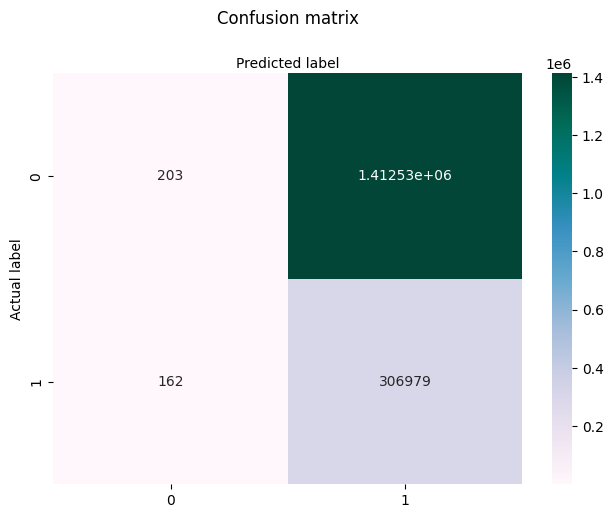

In [49]:
class_names=[0,1]
fig,ax=plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(result1), annot=True, cmap="PuBuGn" ,fmt='g')## visualized confusion matrix using heatmap
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

/Users/hiteshpotla/Documents/vscode/coding/cog_npn/myenv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


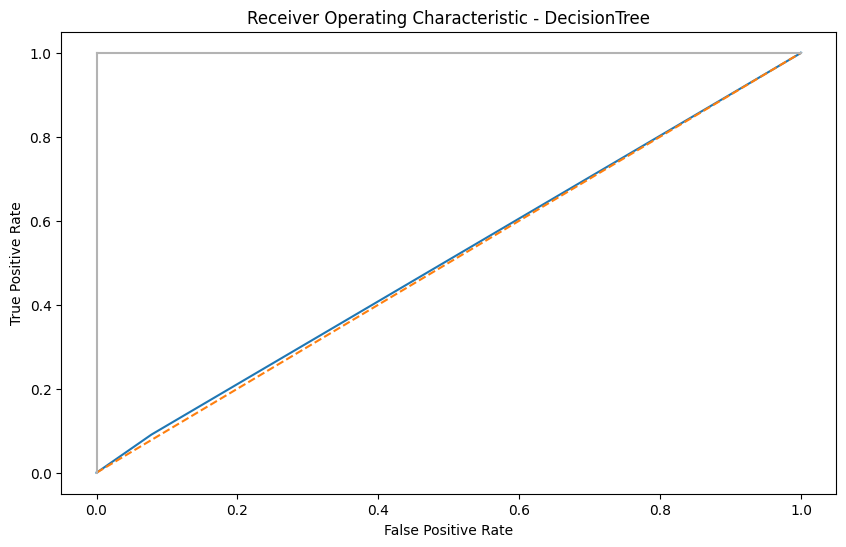

In [50]:
plt.subplots(1, figsize=(10,6))
plt.title('Receiver Operating Characteristic - DecisionTree')
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Accuracy, Precision, and Recall achived by model.

In [51]:
print("Accuracy Achieved:",round(metrics.accuracy_score(y_test, pred)*100,2),'%')
print(' ')
print("Precision Achieved:",round(metrics.precision_score(y_test, pred)*100,2),'%')
print(' ')
print("Recall Achieved:",round(metrics.recall_score(y_test, pred)*100,2),'%')

Accuracy Achieved: 17.86 %
 
Precision Achieved: 17.85 %
 
Recall Achieved: 99.95 %


In [53]:
# from sklearn.model_selection import cross_val_score

# # Cross-validate the Random Forest model
# clf = RandomForestClassifier(
#     random_state=42,
#     max_depth=10,
#     min_samples_leaf=20
# )

# cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy', n_jobs=-1)
# print("Cross-validation accuracy scores:", cv_scores)
# print("Mean CV accuracy: {:.2f}%".format(cv_scores.mean() * 100))